In [1]:
import requests
import json
from langchain_core.tools import tool
import os
import getpass




In [3]:
# os.environ["OPENAI_API_KEY"]

In [4]:
# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [5]:
@tool
def search_flights(origin, destination, departure_date):
    """Fetches the current per gram price of the specified metal.

    Args:
        origin : The name of origin airport.
        destination : The name of destination airport.
        departure_date : The date of departure

    Returns:
        str: The JSON response containing the flight data.

    Raises:
        KeyError: If the response does not contain the expected keys.
    """

    AMADEUS_AUTH_URL = "https://test.api.amadeus.com/v1/security/oauth2/token"
    AMADEUS_FLIGHT_URL = "https://test.api.amadeus.com/v2/shopping/flight-offers"
    CLIENT_ID = "LEIlN75i1aYDmUKtXR8OaCryj6DxA0VG"
    CLIENT_SECRET = "XyeCNwPx54y0dUA3"
    
    data = {
        "grant_type": "client_credentials",
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(AMADEUS_AUTH_URL, data=data, headers=headers)
    if response.status_code == 200:
        token =response.json().get("access_token")

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }
    params = {
        "originLocationCode": origin,
        "destinationLocationCode": destination,
        "departureDate": departure_date,
        "adults": 1,
        "max": 10
    }
    
    response = requests.get(AMADEUS_FLIGHT_URL, headers=headers, params=params)
    
    if response.status_code == 200:
        return str(json.dumps(response.json().get("data", [])))
    else:
        return {"error": "Failed to fetch flights", "status_code": response.status_code}

# origin = "JFK"
# destination = "LAX"
# departure_date = "2025-03-01"



In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
from langchain_openai import ChatOpenAI

tools = [search_flights]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [26]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [27]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [28]:
# Define the function that calls the model
def call_model(state: GraphState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [29]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [30]:
from langgraph.prebuilt import ToolNode

# Node
tools = [search_flights]
tool_node = ToolNode(tools)

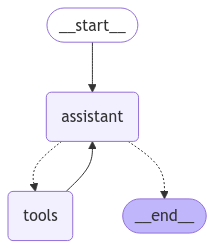

In [31]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="I am looking for a flight from Toronto to Delhi on 24th Feb 2025?")]
result = react_graph.invoke({"messages": messages})

In [40]:
# Get the last message content and format it nicely for display
flight_results = result["messages"][-1].content
print(flight_results)

It seems that there was an error fetching the flight information for your request. Unfortunately, I can't provide the details right now. You might want to check with flight booking websites or apps for the latest information. If there's anything else you'd like to know or try, feel free to ask!


In [41]:
# Agent Logic

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [42]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

In [43]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [45]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [ ]:
flight_search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")